## **Heart Disease Prediction**

### __Importing Dataset__

The dataset was obtained from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease. It is about the Key Heart Disease Indicators, sourced from the 2022 CDC survey involving over 400,000 adults, which primarily examines health-related factors that cause heart disease. Globally, heart disease ranks among the top causes of death across different racial groups, with major risk factors such as high blood pressure, high cholesterol levels, and smoking. Other significant contributors to heart disease include diabetes, obesity, lack of physical activity, and excessive alcohol consumption are taken into consideration. 

In [56]:
# # Initializing Spark session
# spark = utils.initialize_spark_session()

# # Open file for heart disease key indicators
# filename = "dataset/heart_2022_with_nans.csv"
# heart_disease_df = utils.open_csv(spark, filename)
# heart_disease_df.show(5)

+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|Diffi

In [35]:
# heart_disease_df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: integer (nullable = true)
 |-- MentalHealthDays: integer (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: integer (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable 

We will use the same features based from the 2020 version of the dataset, which has 18 features, for simplification purposes. Hence, we'll be dropping the extra features found in 2022 dataset, with the exception for `HeightInMeters` and `WeightInKilograms` which are important when calculating missing values in `BMI`.

In [58]:
# del_columns = ['State', 'LastCheckupTime', 'RemovedTeeth', 'HadDepressiveDisorder', 'HadArthritis', 'HadAngina', 'HadCOPD', 
#                'DeafOrHardOfHearing', 'ECigaretteUsage', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'ChestScan',
#                'DifficultyDressingBathing', 'DifficultyErrands', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'CovidPos',
#                'TetanusLast10Tdap', 'HighRiskLastYear']

# heart_disease_df = heart_disease_df.drop(*del_columns)
# print(f"Number of features: {len(heart_disease_df.columns)}")

Number of features: 20


### __Exploratory Data Analysis__

View the basic statistical details of the dataset

In [37]:
# heart_disease_df.summary().show()

+-------+------+-------------+------------------+-----------------+------------------+------------------+--------------+---------+---------+-------------+----------------+--------------------+-----------------+--------------------+---------------------+---------------+-------------------+-----------------+-----------------+---------------+
|summary|   Sex|GeneralHealth|PhysicalHealthDays| MentalHealthDays|PhysicalActivities|        SleepHours|HadHeartAttack|HadStroke|HadAsthma|HadSkinCancer|HadKidneyDisease|         HadDiabetes|DifficultyWalking|        SmokerStatus|RaceEthnicityCategory|    AgeCategory|     HeightInMeters|WeightInKilograms|              BMI|AlcoholDrinkers|
+-------+------+-------------+------------------+-----------------+------------------+------------------+--------------+---------+---------+-------------+----------------+--------------------+-----------------+--------------------+---------------------+---------------+-------------------+-----------------+---------

Drop all duplicate records fromt the dataset

In [38]:
# print(f"Record count before dropping duplicates => {heart_disease_df.count()}")
# heart_disease_df = heart_disease_df.dropDuplicates()
# print(f"Record count after dropping duplicates  => {heart_disease_df.count()}")

Record count before dropping duplicates => 445132
Record count after dropping duplicates  => 430840


Check all records with missing (or null) values

In [39]:
# print("List of features with missing values:")
# for col_ in heart_disease_df.columns:
#     null_values_count = heart_disease_df.filter(heart_disease_df[col_].isNull()).count()
#     if null_values_count != 0:
#         print(f"- '{col_}' : {null_values_count}")

List of features with missing values:


- 'GeneralHealth' : 1175
- 'PhysicalHealthDays' : 10897
- 'MentalHealthDays' : 9038
- 'PhysicalActivities' : 1069
- 'SleepHours' : 5411
- 'HadHeartAttack' : 3038
- 'HadStroke' : 1530
- 'HadAsthma' : 1746
- 'HadSkinCancer' : 3116
- 'HadKidneyDisease' : 1899
- 'HadDiabetes' : 1060
- 'DifficultyWalking' : 19798
- 'SmokerStatus' : 31115
- 'RaceEthnicityCategory' : 13739
- 'AgeCategory' : 8444
- 'HeightInMeters' : 11308
- 'WeightInKilograms' : 31788
- 'BMI' : 43257
- 'AlcoholDrinkers' : 42161


There are 3,065 records with null values set for `HadHeartAttack`, which is the target variable. Hence, we can simply drop all those records, keeping only those with assigned class labels.

In [40]:
# print(f"Record count before dropping null values in `HadHeartAttack` => {heart_disease_df.count()}")
# heart_disease_df = heart_disease_df.na.drop(subset=["HadHeartAttack"])
# print(f"Record count after dropping null values in `HadHeartAttack`  => {heart_disease_df.count()}")

Record count before dropping null values in `HadHeartAttack` => 430840
Record count after dropping null values in `HadHeartAttack`  => 427802


Check if the target variable `HadHeartAttack` is a binary, wherein it should only have two distinct values, i.e. Yes and No. We will treat this feature as inidividuals with heart disease.

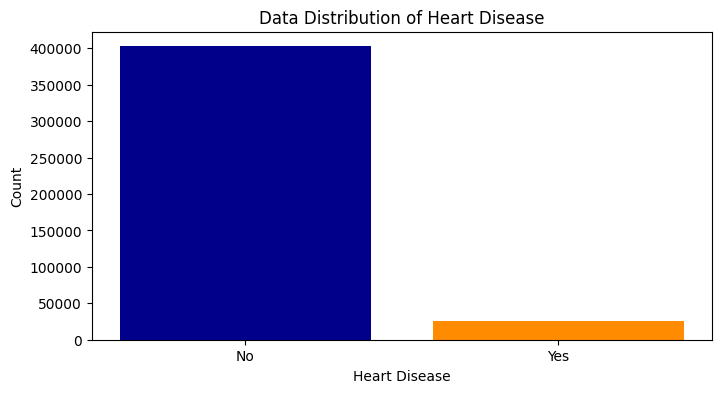

In [41]:
# dv.show_bar_graph(df=heart_disease_df, 
#                   col_="HadHeartAttack", 
#                   figure_size=(8,4),
#                   title='Data Distribution of Heart Disease', 
#                   x_label='Heart Disease', 
#                   y_label='Count', 
#                   x_tick_rotation=None,
#                   bar_color=['darkblue', 'darkorange'])

__Observation:__ The chart reveals that there is an imbalance in the number of records for `HadHeartAttack`, showing an uneven distribution of data between individuals who have the illness and those who do not. This could cause the trained model's predictions for heart disease to be severely biased. To balance the class distribution, we will use 

__insert the process details for balancing the class.....__

When building a model for heart disease, considering a particular ethnicity is very important because different ethnic groups can have distinct genetic, lifestyle, and environmental factors that influence the health of the heart. By focusing on a specific ethnicity, we can develop more personalized and accurate models that account for unique risk factors and characteristics within that population.

In [42]:
# heart_disease_df.groupBy("RaceEthnicityCategory").count().orderBy("count").show(truncate=False)

+-----------------------------+------+
|RaceEthnicityCategory        |count |
+-----------------------------+------+
|Multiracial, Non-Hispanic    |9498  |
|null                         |13407 |
|Other race only, Non-Hispanic|22195 |
|Black only, Non-Hispanic     |34789 |
|Hispanic                     |41973 |
|White only, Non-Hispanic     |305940|
+-----------------------------+------+



Therefore, we'll focus solely on the most number of records for racial group, which is `White only, Non-Hispanic`.

In [43]:
# print(f"Record count before dropping null values in `RaceEthnicityCategory` => {heart_disease_df.count()}")
# heart_disease_df = heart_disease_df.filter(col("RaceEthnicityCategory") == "White only, Non-Hispanic")
# print(f"Record count after dropping null values in `RaceEthnicityCategory`  => {heart_disease_df.count()}")

Record count before dropping null values in `RaceEthnicityCategory` => 427802
Record count after dropping null values in `RaceEthnicityCategory`  => 305940


##### __Data Imputation for Missing Values:__

__a. Data Imputation for Height and Weight__

Check the skewness of `HeightInMeters` and `WeightInKilograms` within each age category to decide on the appropriate imputation method. Based from the results, majority of height values are slightly skewed to the left, while all weight values are skewed to the right. Therefore, __*median*__ imputation will be used to address the missing values in both height and weight as it is more sensitive to outliers than the mean.

__Skewness Interpretation:__
- If skewness is close to 0, it suggests a relatively symmetrical distribution.
- If skewness is significantly positive, it indicates a right-skewed distribution.
- If skewness is significantly negative, it indicates a left-skewed distribution.

In [44]:
# window_spec = Window.partitionBy("Sex", "AgeCategory")

# # Calculate skewness and median using window functions
# skewness_df = heart_disease_df\
#     .withColumn("HeightSkewness", round(skewness("HeightInMeters").over(window_spec), 4))\
#     .withColumn("HeightMedian", median("HeightInMeters").over(window_spec))\
#     .withColumn("HeightCount", count("HeightInMeters").over(window_spec))\
#     .withColumn("WeightSkewness", round(skewness("WeightInKilograms").over(window_spec), 4))\
#     .withColumn("WeightMedian", median("WeightInKilograms").over(window_spec))\
#     .withColumn("WeightCount", count("WeightInKilograms").over(window_spec))\
#     .select("Sex", "AgeCategory", "HeightSkewness", "HeightCount", "HeightMedian", "WeightSkewness", "WeightCount", "WeightMedian")\
#     .distinct().orderBy("Sex", "AgeCategory")

# # Median imputation will be used for both height and weight due to skewed dataset
# heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "HeightInMeters", "HeightMedian")
# heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "WeightInKilograms", "WeightMedian")

# print("Statistical analysis on data imputation for height and weight")
# skewness_df.show(30)

Statistical analysis on data imputation for height and weight
+------+---------------+--------------+-----------+------------+--------------+-----------+------------+
|   Sex|    AgeCategory|HeightSkewness|HeightCount|HeightMedian|WeightSkewness|WeightCount|WeightMedian|
+------+---------------+--------------+-----------+------------+--------------+-----------+------------+
|Female|           null|       -0.1963|       1922|        1.63|        2.4783|       1342|       65.32|
|Female|   Age 18 to 24|       -0.0082|       6351|        1.65|        1.4522|       6351|       66.22|
|Female|   Age 25 to 29|        0.0721|       5746|        1.65|        1.3538|       5746|       72.57|
|Female|   Age 30 to 34|        0.1186|       7421|        1.65|        1.4697|       7421|       72.57|
|Female|   Age 35 to 39|        0.1102|       8778|        1.65|        1.5193|       8778|       73.03|
|Female|   Age 40 to 44|       -0.1519|       9669|        1.65|        1.3259|       8782|       

__b. Data Imputation for BMI__

Body Mass Index (BMI) is a metric calculated based on a person's weight and height. The BMI is often used as an indicator of body fatness and is a screening tool to categorize individuals into different weight status categories, such as underweight, normal weight, overweight, and obesity. The formula is:

$$ BMI = {WeightInKilograms \over HeightInMeters^2} $$

To fill in the missing BMI, we will calculate BMI for records with missing BMI but weight and height are available by using the given formula above.

In [46]:
# bmi_count = heart_disease_df.filter(col("BMI").isNull()).count()
# print(f"Record count with missing BMI before data imputation => {bmi_count}")

# heart_disease_df = dp.impute_bmi(heart_disease_df)

# bmi_count = heart_disease_df.filter(col("BMI").isNull()).count()
# print(f"Record count with missing BMI after data imputation  => {bmi_count}")

Record count with missing BMI before data imputation => 25811
Record count with missing BMI after data imputation  => 0


Use boxplot to check whether there are any outliers present in the BMI dataset. From the chart, a number of outliers are shown due to imbalance data distribution for people with heart disease. Hence, we'll just consider the data an outlier if BMI value is more than 120.

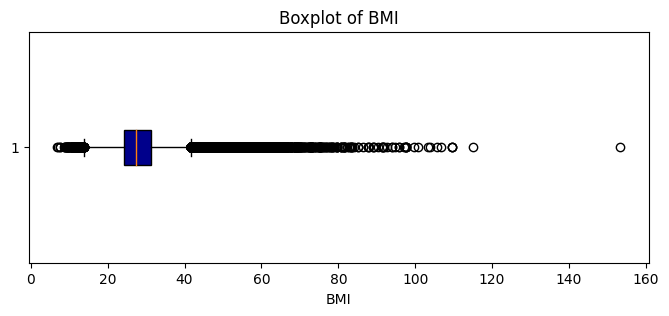

In [47]:
# # Create a boxplot using Matplotlib
# bmi_data = heart_disease_df.select("BMI").rdd.flatMap(lambda x: x).collect()
# dv.show_boxplot_graph(data=bmi_data, figure_size=(8,3), title='Boxplot of BMI', x_label='BMI')

# # Remove outliers from BMI dataset
# heart_disease_df = heart_disease_df.filter(col("BMI") <= 120)

__c. Data Imputation for Age Category__

To fill in the missing age group values, a new column named `WeightStatus` will be created first where its values will be derived from the BMI. The BMI interpretation is based on guidelines available at https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html." This new column will be part of the aggregation to get the age category with the highest count.

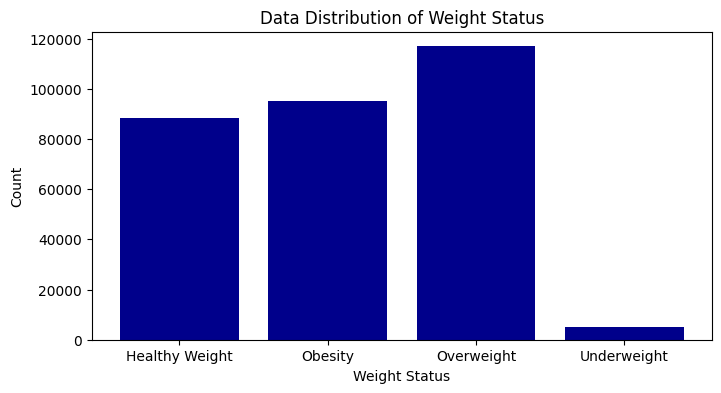

In [48]:
# # Create a new column `WeightStatus` with values based from BMI
# heart_disease_df = heart_disease_df.withColumn("WeightStatus", 
#     when(format_number(col("BMI"), 2).between(0, 18.59), "Underweight")
#     .when(format_number(col("BMI"), 2).between(18.6, 24.99), "Healthy Weight")
#     .when(format_number(col("BMI"), 2).between(25.0, 29.99), "Overweight")
#     .when(format_number(col("BMI"), 2).between(30.0, 200), "Obesity"))
    
# # Show data distribution of weight status
# dv.show_bar_graph(df=heart_disease_df, 
#                   col_="WeightStatus", 
#                   figure_size=(8,4),
#                   title='Data Distribution of Weight Status', 
#                   x_label='Weight Status', 
#                   y_label='Count', 
#                   x_tick_rotation=None)

Calculate the maximum count per `WeightStatus` category given the `AgeCategory`. Output are the `AgeCategory` values that will be imputed to missing age group given the weight status. 

*Example: Most females classified as underweight fall within the age category of 'Age 80 or older.' Hence, that age category value will be used to fill in the missing data for underweight females.*

In [49]:
# window_spec = Window.partitionBy("Sex", "WeightStatus").orderBy(desc("count"))

# age_result = heart_disease_df.groupBy("Sex", "AgeCategory", "WeightStatus").count()\
#     .withColumn("max_count", max("count").over(window_spec))\
#     .filter(col("count") == col("max_count")).drop("max_count")

# heart_disease_df = dp.impute_age_category(heart_disease_df, age_result)

# print("Statistical analysis on data imputation for age group")
# age_result.show()

Statistical analysis on data imputation for age group
+------+---------------+--------------+-----+
|   Sex|    AgeCategory|  WeightStatus|count|
+------+---------------+--------------+-----+
|Female|Age 80 or older|Healthy Weight| 7609|
|Female|   Age 65 to 69|       Obesity| 6041|
|Female|   Age 65 to 69|    Overweight| 6901|
|Female|Age 80 or older|   Underweight|  696|
|  Male|   Age 18 to 24|Healthy Weight| 4065|
|  Male|   Age 65 to 69|       Obesity| 5806|
|  Male|   Age 65 to 69|    Overweight| 7231|
|  Male|   Age 18 to 24|   Underweight|  401|
+------+---------------+--------------+-----+



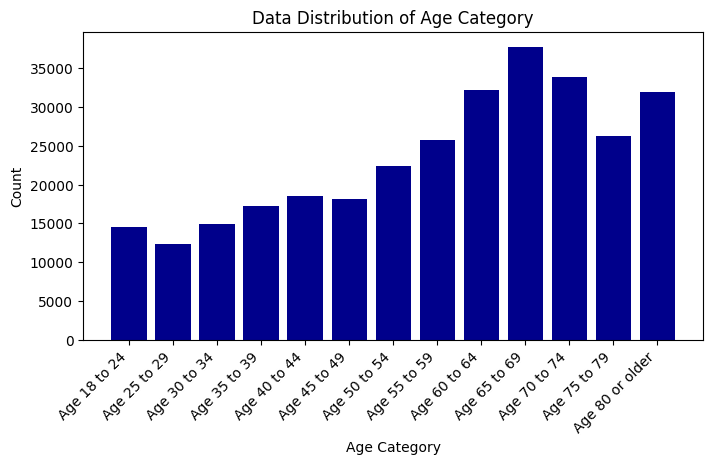

In [50]:
# # Show data distribution of age category
# dv.show_bar_graph(df=heart_disease_df, 
#                   col_="AgeCategory", 
#                   figure_size=(8,4),
#                   title='Data Distribution of Age Category', 
#                   x_label='Age Category', 
#                   y_label='Count', 
#                   x_tick_rotation=45)

In [51]:
# # Drop `WeightStatus`, `HeightInMeters`, `WeightInKilograms` columns since they are correlated to BMI
# heart_disease_df = heart_disease_df.drop(*['WeightStatus', 'HeightInMeters', 'WeightInKilograms'])
# print(f"Columns: {heart_disease_df.columns}")

Columns: ['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'PhysicalActivities', 'SleepHours', 'HadHeartAttack', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadKidneyDisease', 'HadDiabetes', 'DifficultyWalking', 'SmokerStatus', 'RaceEthnicityCategory', 'AgeCategory', 'BMI', 'AlcoholDrinkers']


__d. Data Imputation for General Health__

### __Balancing Data Distribution of Target Feature__

### __Feature Selection and Feature Engineering__

### __Model Creation and Evaluation__

##### Logistic Regression

##### Decision Tree

##### Random Forests

##### Gradient Boosted Tree

### __Hyper Parameter Tuning__

### __References__

- https://towardsdatascience.com/apache-spark-performance-boosting-e072a3ec1179
- https://medium.com/@adrianchang/apache-spark-checkpointing-ebd2ec065371